In [2]:
%load_ext autoreload
%autoreload 2
import sys
import os
from decimal import *
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import gc


from IPython import display
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

sys.path.append('../dataset_construction')
sys.path.append('../../util')
from pano_utils import *
import panoseti_file_interfaces as pfi
import pff

In [9]:
def load_ph_data(data_dir, run_dir, module_id):
    """
    Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
    """
    ori = pfi.ObservingRunInterface(data_dir, run_dir)
    if module_id not in ori.obs_pff_files:
        print(f'No module with ID "{module_id}"\n'
              f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
        return
    columns = [
        'wr_timestamp (s)',
        'quabo_num',
        'pkt_num',
        'pkt_tai',
        'pkt_nsec',
        'tv_sec',
        'tv_usec',
        # 'img_data'
    ]
    ph_df = pd.DataFrame(columns=columns)

    low = 1721883600 + 27
    high = 1721883600 + 27 + 1000
    
    for ph_file in ori.obs_pff_files[module_id]["ph"]:
        fname = ph_file["fname"]
        fpath = f'{data_dir}/{run_dir}/{fname}'
        with open(fpath, 'rb') as fp:
            frame_iterator = ori.pulse_height_frame_iterator(fp, 1)
            for j, img in frame_iterator:
                ts = pff.wr_to_unix(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                if ts < low:
                    continue
                elif high < ts:
                    break
                j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
                # j['img_data'] = img
                ph_df.loc[len(ph_df)] = j
    ph_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
    ph_df = ph_df.sort_values(by='wr_timestamp (s)')
    return ph_df

# def load_img_data(data_dir, run_dir, module_id):
#     """
#     Create a pd.DataFrame containing the header information of every PH event in data_dir/run_dir for module_id.
#     """
#     ori = pfi.ObservingRunInterface(data_dir, run_dir)
#     if module_id not in ori.obs_pff_files:
#         print(f'No module with ID "{module_id}"\n'
#               f'Available module_ids:\n\t{list(ori.obs_pff_files.keys())}')
#         return
#     columns = [
#         'wr_timestamp (s)',
#         'quabo_num',
#         'pkt_num',
#         'pkt_tai',
#         'pkt_nsec',
#         'tv_sec',
#         'tv_usec',
#         # 'img_data'
#     ]
#     img_df = pd.DataFrame(columns=columns)
    
#     for img_file in ori.obs_pff_files[module_id]["img"]:
#         fname = img_file["fname"]
#         fpath = f'{data_dir}/{run_dir}/{fname}'
#         with open(fpath, 'rb') as fp:
#             fp.seek(
#             frame_iterator = ori.image_frame_iterator(fp, 1)
#             for j, img in frame_iterator:
#                 print(j)
#                 j = j['quabo_0']
#                 j['wr_timestamp (s)'] = pff.wr_to_unix_decimal(j['pkt_tai'], j['pkt_nsec'], j['tv_sec'])
#                 # j['img_data'] = img
#                 img_df.loc[len(ph_df)] = j
#     img_df['unix_timestamp'] = pd.to_datetime(ph_df['wr_timestamp (s)'].astype(np.float64), unit = 's', utc=True)
#     img_df = img_df.sort_values(by='wr_timestamp (s)')
#     return img_df

def plot_img(data, cbar=False, ax=None, vmin=-50, vmax=50, cmap='rocket'):
    with np.errstate(divide='ignore'):
        div = 1 / np.sqrt(abs(data))
        div = np.nan_to_num(div, nan=1)
    
    if ax:
        im_orig = ax.imshow(
            data * div, vmin=vmin, vmax=vmax, cmap=cmap,
        )
    else:
        im_orig = plt.imshow(
            data *  div, vmin=vmin, vmax=vmax, cmap=cmap#cmap='crest_r',
        )
    if cbar:
        cbar_orig = plt.colorbar(im_orig, label='Sqrt Counts', fraction=0.046, location='right')
    plt.axis('off')

In [10]:
data_dir = '/Users/nico/Downloads/panoseti_test_data/obs_data/data'
# run_dir = 'obs_Lick.start_2023-08-01T05:14:21Z.runtype_sci-obs.pffd'
# run_dir = 'obs_Lick.start_2023-08-29T04:49:58Z.runtype_sci-obs.pffd'
run_dir = 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd'

ori = pfi.ObservingRunInterface(data_dir, run_dir, do_baseline_subtraction=True)

	processing module 1


In [11]:
ori.obs_pff_files

{1: {'img': [{'fname': 'start_2024-07-25T04_34_46Z.dp_img16.bpp_2.module_1.seqno_0.pff',
    'seqno': 0,
    'nframes': 1574804,
    'first_unix_t': 1721882092.6910074,
    'last_unix_t': 1721883667.4940076}],
  'ph': [{'fname': 'start_2024-07-25T04_34_46Z.dp_ph256.bpp_2.module_1.seqno_0.pff',
    'seqno': 0,
    'nframes': 265275,
    'first_unix_t': 1721882094.288621,
    'last_unix_t': 1721895587.1269574}],
  'baseline_df':      window_left_unix_t   window_right_unix_t  \
  0                    -1  1721882101.691007488   
  100                  -1  1721883101.691007488   
  101                  -1  1721883111.691007488   
  102                  -1  1721883121.691007488   
  103                  -1  1721883131.691007488   
  ..                  ...                   ...   
  53                   -1  1721882631.691007488   
  54                   -1  1721882641.691007488   
  55                   -1  1721882651.691007488   
  48                   -1  1721882581.691007488   
  156     

3912.5
3932.5
3839.5
3904.5


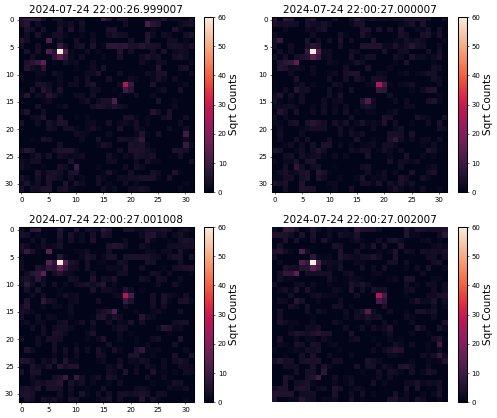

In [47]:
from datetime import timedelta
import matplotlib as mpl
pano_frame_seek_info = ori.module_file_time_seek(1, float(1721883600 + 27))
mpl.rcParams['figure.dpi'] = 50


nrows = 2
ncols = 2
f, axs = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*5))

for i in range(nrows):
    for j in range(ncols):
        ax = axs[i, j]
        frame_offset = i * nrows + j
        data, meta = ori.stack_frames(
            pano_frame_seek_info['file_idx'],
            pano_frame_seek_info['frame_offset'] + frame_offset,
            module_id=1,
            subtract_baseline=True
        )
        print(np.max(data))
        ts = meta['start_unix_t']
        # print(ts)
        ts = datetime.utcfromtimestamp(float(ts)) - timedelta(hours=7, minutes=0)
        # print(ts)
        
        plot_img(data, cbar=True, vmin=0, vmax=60, cmap='rocket', ax=ax)
        ax.set_title(f'{ts}')
plt.show()

In [41]:
ori = pfi.ObservingRunInterface(data_dir, run_dir, do_baseline_subtraction=True)

	processing module 1


1.0

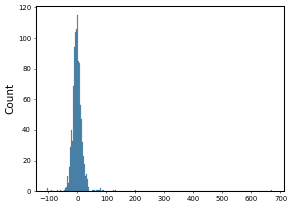

In [82]:
sns.histplot(data.ravel())
np.percentile(np.sqrt(np.abs(data)), 5)


In [143]:
from datetime import timedelta, tzinfo, timezone
import matplotlib as mpl
pano_frame_seek_info = ori.module_file_time_seek(1, float(1721883600 + 25))
mpl.rcParams['figure.dpi'] = 75
mpl.rcParams["savefig.dpi"] = 'figure'
mpl.rcParams["savefig.format"] = 'png'
nframes = 4600
# f, axs = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*5))
idx = 0
fnames = []
os.makedirs('explore_frames', exist_ok=True)
for i in range(nframes):
    # ax = axs[i, j]
    plt.figure(figsize=(5,5))
    frame_offset = i
    data, meta = ori.stack_frames(
        pano_frame_seek_info['file_idx'],
        pano_frame_seek_info['frame_offset'] + i,
        module_id=1,
        subtract_baseline=True
    )
    ts = meta['start_unix_t']
    ts = datetime.utcfromtimestamp(float(ts)) #- timedelta(hours=7, minutes=0)
    ts = ts.astimezone(timezone(timedelta(hours=-7)))
    plot_img(data, cbar=True, vmin=-1, vmax=60, cmap='rocket')
    plt.title(f'{ts.isoformat()}')
    fname = f"explore_frames/{idx}"
    plt.savefig(fname)
    plt.close()
    # plt.show()
    fnames.append(fname + '.png')
    idx += 1

In [144]:
import imageio.v2 as imageio
images = []
for filename in fnames:
    images.append(imageio.imread(filename))
imageio.mimsave('explore_frames/panoseti_anomaly.gif', images, duration=1/1000)

KeyboardInterrupt: 

In [ ]:
pf = load_ph_data(data_dir, run_dir, 1)

In [8]:
def plot_grid(imgs, title, cols=10, rows_per_plot=10, vmin=-100, vmax=100, cmap='rocket'):
    rows = math.ceil(len(imgs) / cols)
    num_subplots = rows_per_plot * cols
    title_added = False
    for plot_idx in range(math.ceil(rows / rows_per_plot)):
        fig = plt.figure(figsize=(3. * rows_per_plot, 3. * cols))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                         nrows_ncols=(rows_per_plot, cols),  # creates width x height grid of axes
                         axes_pad=0.3,  # pad between axes in inch.
                         )
        for i in range(num_subplots):
            img_idx = plot_idx * num_subplots + i
            if img_idx < len(imgs):
                ax = grid[i]
                img = imgs[img_idx]
                plot_img(img, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
                if not title_added:
                    ax.set_title(title)
                    title_added = True
        plt.show()
        plt.close()

In [9]:
?ori.stack_frames

Signature:
ori.stack_frames(
    start_file_idx,
    start_frame_offset,
    module_id,
    subtract_baseline=False,
)
Docstring:
Stacks consecutive imaging frames until the cumulative imaging time equals stacked_integration_usec.
    1) Evenly samples image frames between the start frame, specified by start_file_idx and start_frame_offset, and
    the frame with timestamp now - stacked_integration_ussec.
    2) Then aggregates the frames according to the aggregation procedure ['sum', 'mean'], specified as a class variable.

By default, stack until a total of 6ms of observational data is accumulated. e.g.:
- For a 100us integration time, add 60 images together.
- For a 2000us integration time, add 3 images together.

@param start_file_idx: sequence number of PFF imaging file in which frame sampling should begin.
@param start_frame_offset: frame offset within the specified file, relative to the earliest frame in this file.
@return: tuple of (Stacked 32x32 image frame, stacked metadata d

<Axes: ylabel='Density'>

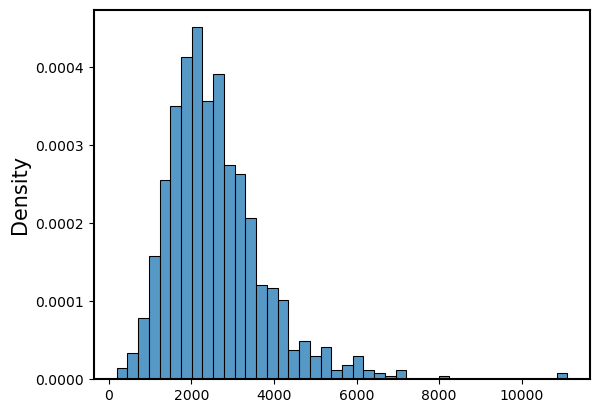

In [11]:
img, stacked_meta = ori.stack_frames(0, 0, 1)
# plot_img(img, vmin=10, vmax=15, cmap='rocket')
sns.histplot(
    img.ravel(),
    stat='density',
    label='pixel_stats',
)

In [9]:
# np.random.seed(50)
# module_id = 1
# for k in [10]:
#     spatial_medians, buffer, buffer_no_spatial_medians, supermedian, flat, spdf = ori.compute_imaging_baselines(
#         module_id, spatial_median_window_usec=k*10**6, max_samples_per_window = 10
#     )
#     sm_idxs = np.linspace(0, len(spatial_medians) - 1, 50).astype(int)
#     bf_idxs = np.linspace(0, len(buffer) - 1, 50).astype(int)
#     bfnsm_idxs = np.linspace(0, len(buffer_no_spatial_medians) - 1, 50).astype(int)
#     flat_idxs = np.linspace(0, len(flat) - 1, 50).astype(int)
#     print('done')
    # plot_grid(spatial_medians[sm_idxs, :, :], f'(spatial medians) window_length = {k} s', vmin=10, vmax=15)
    # # plot_grid(buffer[bf_idxs, :, :], f'(original) window_length = {k} s', vmin=10, vmax=15)
    # plot_grid(buffer_no_spatial_medians[bfnsm_idxs, :, :], f'orig - (spatial median): window_length = {k} s', vmin=-15, vmax=15, cmap='icefire')
    # plot_grid(flat[flat_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

In [14]:
data_dir = '/Users/nico/Downloads/panoseti_test_data/obs_data/data'
run_dir = 'obs_Lick.start_2023-08-01T05:14:21Z.runtype_sci-obs.pffd'
# run_dir = 'obs_Lick.start_2023-08-29T04:49:58Z.runtype_sci-obs.pffd'
run_dir = 'obs_Lick.start_2024-07-25T04:34:06Z.runtype_sci-data.pffd'


# Compute spatial median baselines
ori = pfi.ObservingRunInterface(data_dir, run_dir, do_baseline_subtraction=True)

	processing module 1


In [25]:
# Test baseline subtraction datastructure
module_id = 1
baseline_df = ori.obs_pff_files[module_id]['baseline_df']
tmin = min(baseline_df['window_left_unix_t'])
tmax = max(baseline_df['window_right_unix_t'])
test_times = []

ntimes = 1000

for dt in np.linspace(0, float(tmax - tmin), ntimes):
    test_times.append(tmin + Decimal(str(dt)))

flat_imgs = pd.DataFrame(columns=['timestamp', 'img'])

for i in range(len(test_times)):
    t0 = test_times[i]
    pano_frame_seek_info = ori.module_file_time_seek(module_id, float(t0))
    if pano_frame_seek_info is None:
        # print('Failed to find matching panoseti frames. Skipping...')
        continue
    stacked_img0, stacked_meta = ori.stack_frames(
        pano_frame_seek_info['file_idx'],
        pano_frame_seek_info['frame_offset'],
        module_id,
        subtract_baseline=True
    )
    flat_imgs.loc[len(flat_imgs)] = {
        'timestamp': t0,
        'img': stacked_img0
    }
    # flat_imgs.append(stacked_img0)

    # t1 = test_times[i] + Decimal('60')
    # pano_frame_seek_info = ori.module_file_time_seek(module_id, float(t1))
    # if pano_frame_seek_info is None:
    #     # print('Failed to find matching panoseti frames. Skipping...')
    #     continue
    # stacked_img1, stacked_meta = ori.stack_frames(
    #     pano_frame_seek_info['file_idx'],
    #     pano_frame_seek_info['frame_offset'],
    #     module_id,
    # )
    # flat_imgs.append(stacked_img1 - stacked_img0)

# Plot baseline-subtracted images.
plot_grid(flat_imgs, 'auto-flattened-imgs', vmin=-50, vmax=50, cmap='icefire')
plt.show()

# print(f'Min diff = {min(diffs)}, Max diff = {max(diffs)}')
mu = np.mean(np.array(flat_imgs).ravel())
std = np.std(np.array(flat_imgs).ravel())
sns.histplot(
    np.array(flat_imgs).ravel(),
    stat='density',
    label='orig - (spatial medians) - supermedian',
    binrange=[mu - 10 * std, mu + 10 * std]
)

IndexError: iloc cannot enlarge its target object

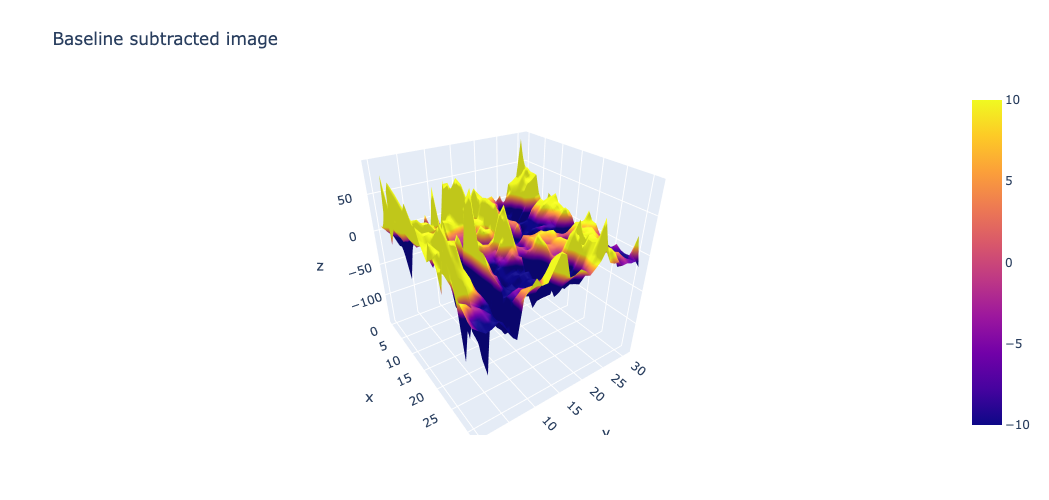

In [35]:
# Read data from a csv
img = flat_imgs[-1]
div = 1 / np.sqrt(abs(img))
div = np.nan_to_num(div, nan=1)
z  = img

fig = go.Figure(data=[go.Surface(z=z, cmin=-10, cmax=10)])
fig.update_layout(title='Baseline subtracted image', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [ ]:
plot_grid(np.fft.fft(flat_imgs), 'auto-flattened-imgs', vmin=-10, vmax=10, cmap='icefire')

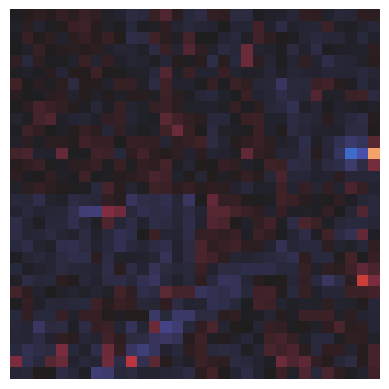

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_88556/2438112594.py:2: RuntimeWarning:

divide by zero encountered in divide



False

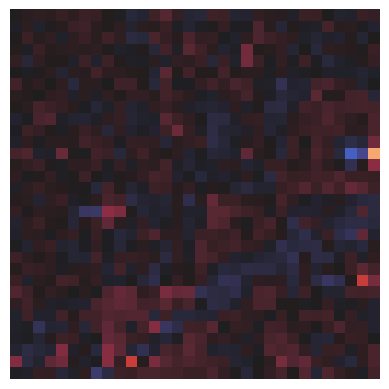

In [28]:
idx = 10
img = buffer[idx] - spdf['spatial_median_img'].iloc[idx]

plot_img(img, vmin=-10, vmax=10, cmap='icefire')
plt.show()
plot_img(flat[idx], vmin=-10, vmax=10, cmap='icefire')
np.allclose(img - flat[idx], np.zeros((32,32)))

In [28]:
x = np.zeros((5, 32, 32))
len(x)

5

/var/folders/5q/9jqcz6pj3053zxqf_d22qb680000gr/T/ipykernel_27162/1652870394.py:2: RuntimeWarning: divide by zero encountered in divide
  div = 1 / np.sqrt(abs(data))


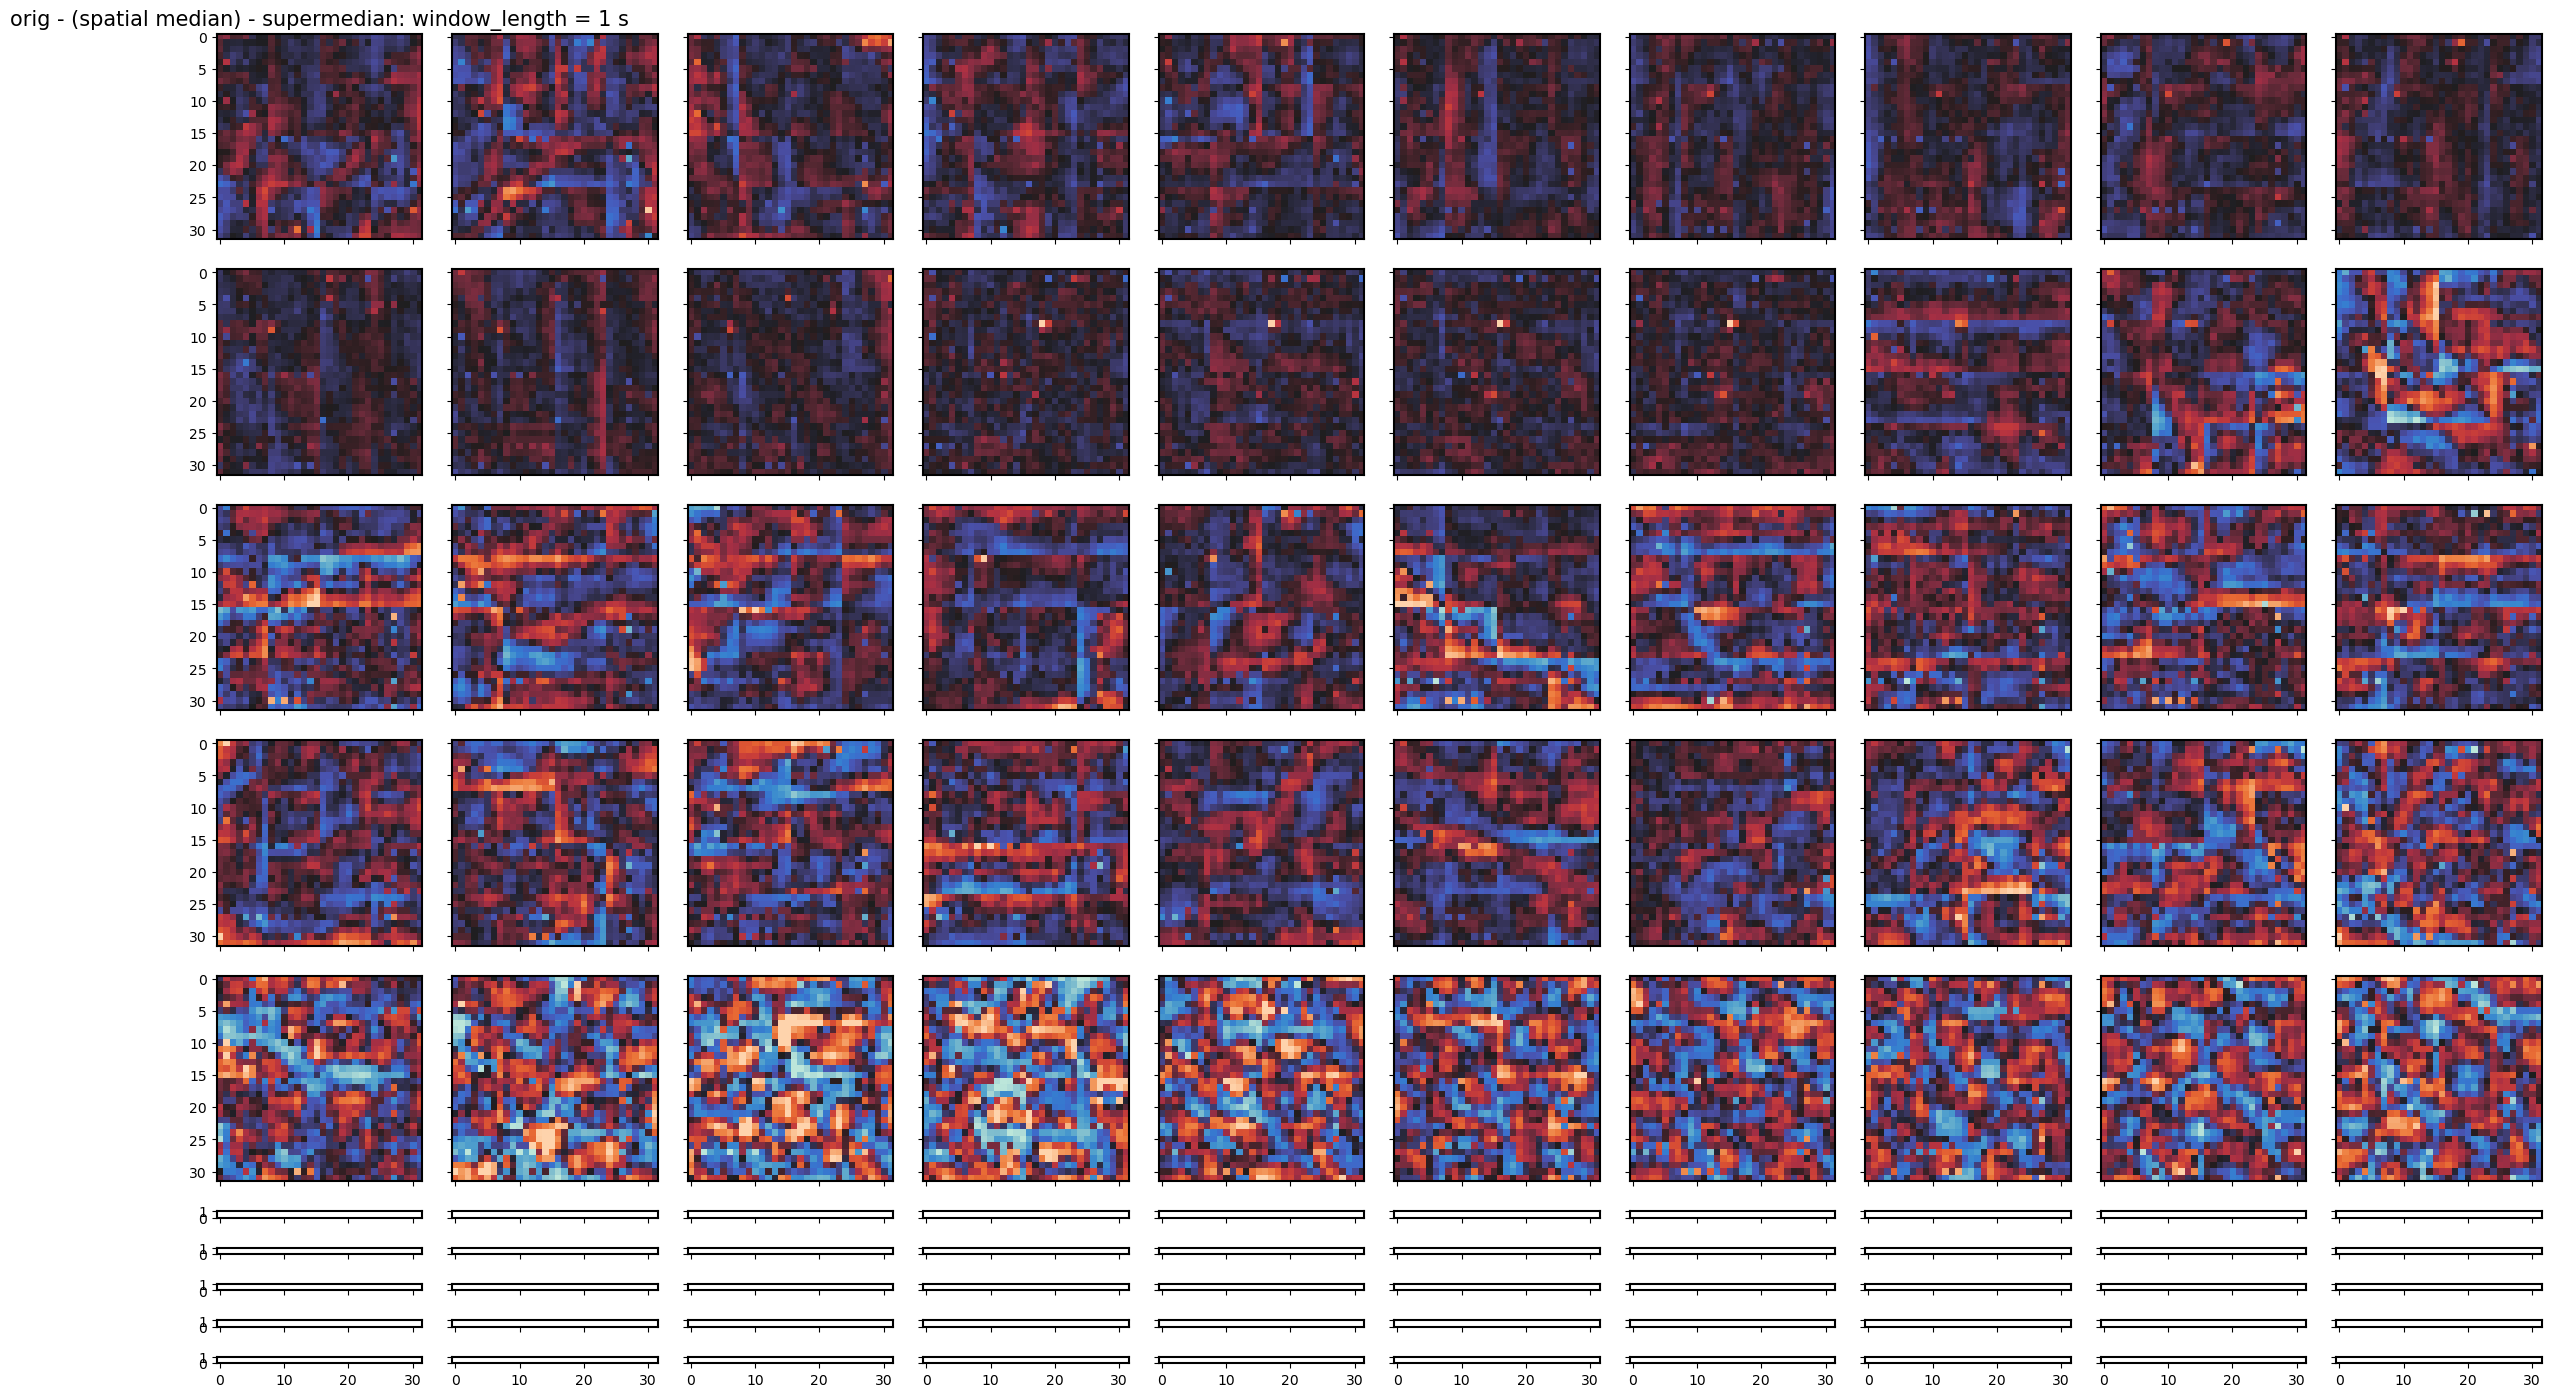

In [255]:
# nstack = 1
# flat_stacked = np.sum(
#     (buffer - supermedian * 2).reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:])),
#     axis=0
# )
flat_idxs = np.linspace(0, len(flat) - 1, 50).astype(int)
plot_grid(flat[flat_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

In [256]:
(nstack * ori.intgrn_usec / 1e6) * 60000

6.0

In [ ]:
nstack = 1
flat_stacked = flat.reshape((nstack, flat.shape[0] // nstack, *flat.shape[1:]))
flat_diffs = np.diff(np.sum(flat_stacked, axis=0)[::100], axis=0) 
flat_diff_idxs = np.linspace(0, len(flat_diffs) - 1, min(len(flat_diffs), 150)).astype(int)
plot_grid(flat_diffs[flat_diff_idxs, :, :], f'orig - (spatial median) - supermedian: window_length = {k} s', vmin=-10, vmax=10, cmap='icefire')

In [18]:
plt.figure(figsize=(20,10))
binrange = [-100, 250]
bins = 175

sm_idxs = np.linspace(0, len(spatial_medians) - 1, 500).astype(int)
bf_idxs = np.linspace(0, len(buffer) - 1, 500).astype(int)
bfnsm_idxs = np.linspace(0, len(buffer_no_spatial_medians) - 1, 500).astype(int)
flat_idxs = np.linspace(0, len(flat) - 1, 500).astype(int)

sns.histplot(
    supermedian.ravel(), 
    stat='density', 
    label='supermedian', 
    binrange=binrange,
    bins=bins
)
sns.histplot(
    spatial_medians[sm_idxs, :, :].ravel(),
    stat='density',
    label='spatial_medians',
    binrange=binrange,
    bins=bins)
sns.histplot(
    buffer[bf_idxs, :, :].ravel(),
    stat='density',
    label='orig',
    binrange=binrange,
    bins=bins
)
sns.histplot(
    buffer_no_spatial_medians[flat_idxs, :, :].ravel(),
    stat='density',
    label='orig - (spatial medians)',
    binrange=binrange, bins=bins
)
sns.histplot(
    flat[flat_idxs, :, :].ravel(),
    stat='density',
    label='orig - (spatial medians) - supermedian',
    binrange=binrange,
    bins=bins
)

# sns.histplot(
#     flat_diffs[flat_diff_idxs, :, :].ravel(),
#     stat='density',
#     label='flat diffs',
#     binrange=binrange,
#     bins=bins
# )

# plt.xlim(-100, 100)
plt.xlabel('counts')
plt.legend()

NameError: name 'spatial_medians' is not defined

<Figure size 2000x1000 with 0 Axes>